In [ ]:
from PIL import Image
import cv2
import os
import matplotlib.pyplot as plt
import random
import pandas as pd
import scipy.io
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import lightning.pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
import numpy as np
from tqdm import tqdm
from pytorch_metric_learning import losses, miners

device = 'cuda'

In [10]:
mat = scipy.io.loadmat('./devkit/cars_train_annos.mat')
fname_to_class = {fname:cl-1 for fname, cl in zip([i[0] for i in mat['annotations'][0]['fname']],
                                                [i[0][0] for i in mat['annotations'][0]['class']])}
cars_meta = scipy.io.loadmat('./devkit/cars_meta.mat')
id_to_car = {idx: car[0] for idx, car in enumerate(cars_meta['class_names'][0])}

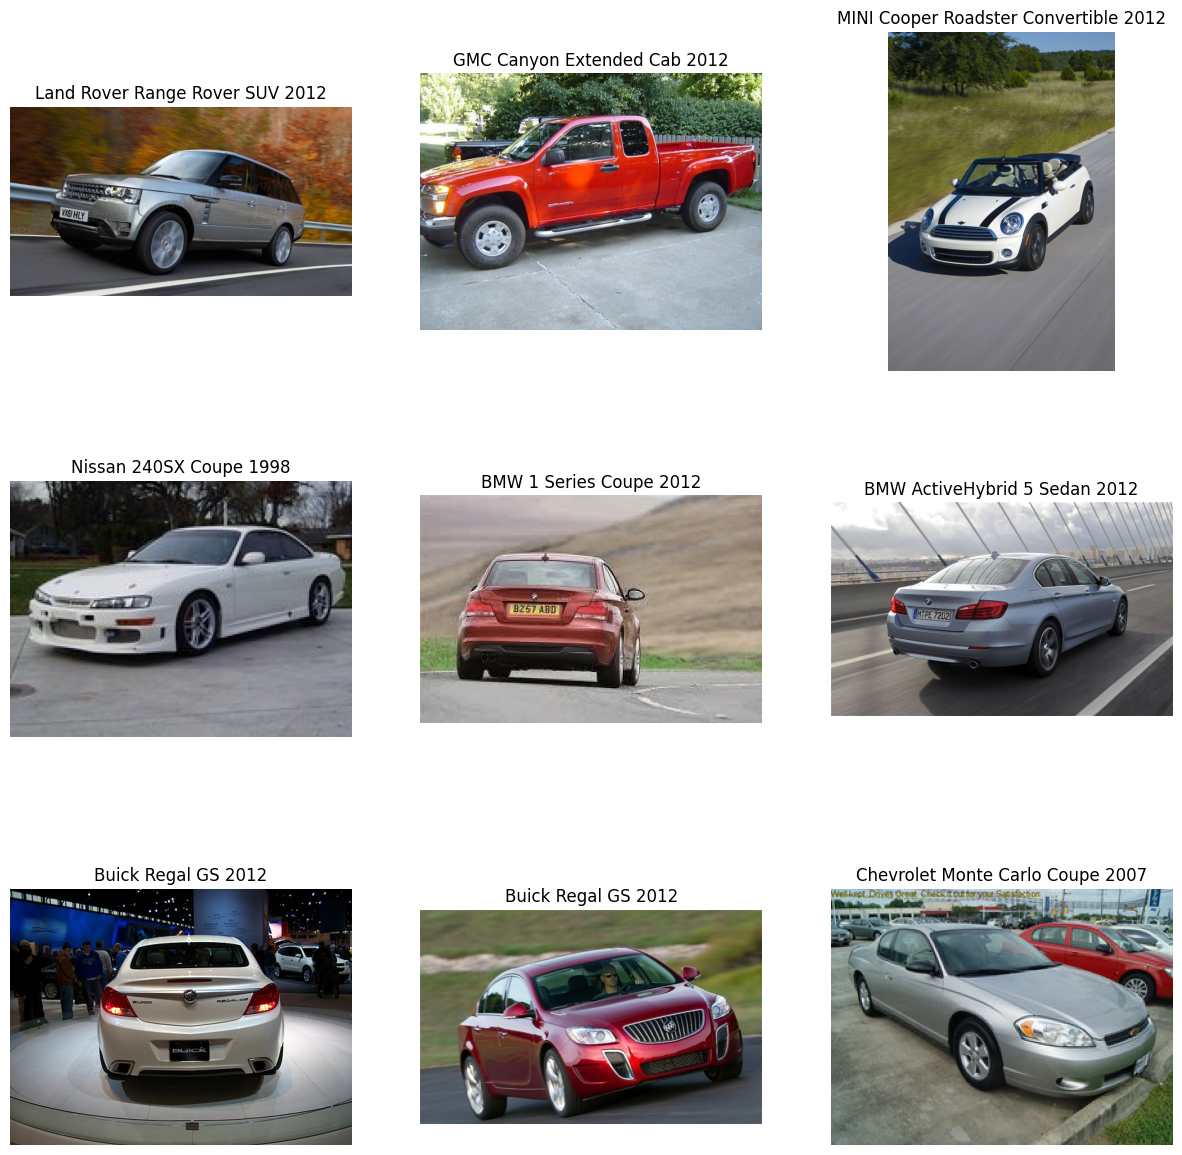

In [28]:
ADD_PATH = './cars_train/cars_train'

num_imgs = 9
cols = 3
rows = num_imgs // cols
fig, ax = plt.subplots(rows, cols, figsize = (15, 15))
for idx, im_idx in enumerate(random.sample([i for i in range(len(fname_to_class))], num_imgs)):
    filename, cl_id = list(fname_to_class.items())[im_idx]
    temp_image = cv2.imread(os.path.join(ADD_PATH, filename))
    temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
    ax[idx//cols][idx%cols].imshow(temp_image)
    ax[idx//cols][idx%cols].set_title(f'{id_to_car[cl_id]}')
    ax[idx//cols][idx%cols].axis('off')

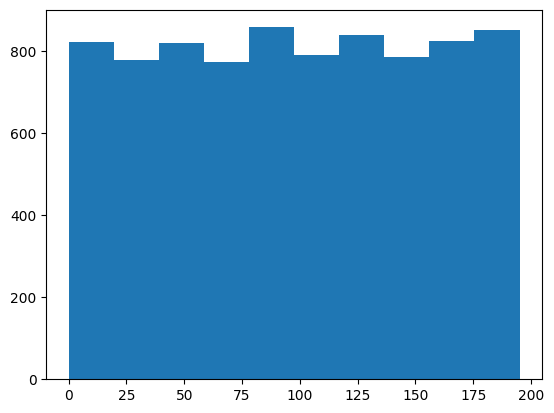

In [16]:
plt.hist(fname_to_class.values())
plt.show()

Добавим train-аугментации:

In [ ]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(size=(256, 256)),

    transforms.RandomCrop(size=(224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),

    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [38]:
class CarDataset(Dataset):
    def __init__(self, cars_items, transforms):
        self.cars = cars_items
        self.transforms = transforms

    def __len__(self):
        return len(self.cars)

    def __getitem__(self, idx):
        filename, cl_id = self.cars[idx]
        image = cv2.imread(os.path.join(ADD_PATH, filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transforms:
            image = self.transforms(image)

        sample = {'image': image, 'label': cl_id, 'filename': filename}
        return sample

In [62]:
data = list(fname_to_class.items())

random.shuffle(data)

train_frac = 0.8
train_data = data[:int(len(data) * train_frac)]
val_data = data[int(len(data) * train_frac):]

train_dataset = CarDataset(train_data, train_transforms)
val_dataset = CarDataset(val_data, val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
valid_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Реализуем метрики Precision@k, recall@k и mAP:

In [63]:
def precision_at_k(embedding, label, other_embeddings, other_labels, k):
    distances = np.linalg.norm(other_embeddings - embedding, axis=1)

    nearest_indices = np.argsort(distances)[:k]
    nearest_labels = other_labels[nearest_indices]

    good = np.sum(nearest_labels == label)
    return good / k

def recall_at_k(embedding, label, other_embeddings, other_labels, k):
    distances = np.linalg.norm(other_embeddings - embedding, axis=1)

    nearest_indices = np.argsort(distances)[:k]
    nearest_labels = other_labels[nearest_indices]

    good_found = np.sum(nearest_labels == label)
    good_total = np.sum(other_labels == label)

    if good_total > 0:
        result = good_found / good_total
    else:
        result = 0.0

    return result

def average_precision(embedding, label, other_embeddings, other_labels, k):

    distances = np.linalg.norm(other_embeddings - embedding, axis=1)

    sorted_indices = np.argsort(distances)
    sorted_labels = other_labels[sorted_indices]

    is_good = (sorted_labels == label).astype(float)

    precisions = []
    good_count = 0
    for i in range(min(len(is_good), k)):
        if is_good[i] == 1:
            good_count += 1
            precision_at_i = good_count / (i + 1)
            precisions.append(precision_at_i)

    if precisions:
        result = np.mean(precisions)
    else:
        result = 0.0

    return result

In [64]:
def three_metrics(embeddings, labels, k=5):
    precisions = []
    recalls = []
    aps = []

    n = len(embeddings)

    for i in range(n):
        embedding = embeddings[i]
        label = labels[i]

        other_embeddings = np.concatenate([embeddings[:i], embeddings[i+1:]])
        other_labels = np.concatenate([labels[:i], labels[i+1:]])

        prec = precision_at_k(embedding, label, other_embeddings, other_labels, k)
        rec = recall_at_k(embedding, label, other_embeddings, other_labels, k)
        ap = average_precision(embedding, label, other_embeddings, other_labels, k)

        precisions.append(prec)
        recalls.append(rec)
        aps.append(ap)

    return np.mean(precisions), np.mean(recalls), np.mean(aps)

In [72]:
class CarEmbedder(pl.LightningModule):
    def __init__(self, num_classes, learning_rate=1e-4, emb_size=512, margin=0.2):
        super().__init__()
        self.learning_rate = learning_rate
        self.emb_size = emb_size
        self.margin = margin
        self.num_classes = num_classes

        self.validation_embeddings = []
        self.validation_labels = []

        self.backbone = torchvision.models.resnet101(pretrained=True)
        self.backbone.fc = nn.Sequential(
            nn.Linear(in_features=2048, out_features=emb_size),
            nn.BatchNorm1d(emb_size),
            nn.ReLU(),
            nn.Linear(in_features=emb_size, out_features=emb_size)
        )

        self.triplet_loss = losses.TripletMarginLoss(margin=margin)
        self.miner = miners.TripletMarginMiner(margin=margin, type_of_triplets="semihard")

        self.save_hyperparameters()

    def forward(self, x):
        return self.backbone(x)

    def training_step(self, batch, batch_idx):
        images = batch['image']
        labels = batch['label'].long()

        embeddings = self(images)

        hard_pairs = self.miner(embeddings, labels)
        triplet_loss = self.triplet_loss(embeddings, labels, hard_pairs)

        self.log("train_triplet_loss", triplet_loss, prog_bar=True)

        return triplet_loss

    def on_validation_epoch_start(self):
        self.validation_embeddings.clear()
        self.validation_labels.clear()

    def validation_step(self, batch, batch_idx):
        images = batch['image']
        labels = batch['label'].long()

        embeddings = self(images)

        hard_pairs = self.miner(embeddings, labels)
        triplet_loss = self.triplet_loss(embeddings, labels, hard_pairs)

        self.log("val_triplet_loss", triplet_loss, prog_bar=True)

        self.validation_embeddings.append(embeddings.cpu())
        self.validation_labels.append(labels.cpu())

        return {'embeddings': embeddings.cpu(), 'labels': labels.cpu()}

    def on_validation_epoch_end(self):
        if not self.validation_embeddings:
            return

        all_embeddings = torch.cat(self.validation_embeddings).numpy()
        all_labels = torch.cat(self.validation_labels).numpy()

        precision, recall, mAP = three_metrics(all_embeddings, all_labels, k=5)

        self.log("val_precision_at_5", precision, prog_bar=True)
        self.log("val_recall_at_5", recall, prog_bar=True)
        self.log("val_mAP", mAP, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        return [optimizer], [scheduler]

In [73]:
pl_model = CarEmbedder(num_classes=len(id_to_car), learning_rate=1e-4, emb_size=512)

checkpoint_callback = ModelCheckpoint(
    monitor='val_mAP',
    mode='max',
    save_top_k=3,
    filename='car-embedder-{epoch:02d}-{val_mAP:.3f}'
)

early_stopping = EarlyStopping(monitor="val_mAP", mode="max", patience=5)
lr_monitor = LearningRateMonitor(logging_interval='step')

trainer = pl.Trainer(
    max_epochs=30,
    accelerator=device,
    devices=1,
    callbacks=[checkpoint_callback, early_stopping, lr_monitor],
    log_every_n_steps=10
)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 H

In [74]:
trainer.fit(model=pl_model, train_dataloaders=train_loader, val_dataloaders=valid_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | backbone     | ResNet             | 43.8 M | train
1 | triplet_loss | TripletMarginLoss  | 0      | train
2 | miner        | TripletMarginMiner | 0      | train
------------------------------------------------------------
43.8 M    Trainable params
0         Non-trainable params
43.8 M    Total params
175.252   Total estimated model params size (MB)
296       Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | backbone     | ResNet             | 43.8 M | train
1 | triplet_loss | TripletMarginLoss  | 0      | train
2 | miner        | TripletMarginMiner | 0      | trai

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 29. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]